In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
import GCRCatalogs
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [9]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2920943
nombre de galaxies centrales = 2669420
pourcentage de galaxies centrales = 91.38897951791596 %
nombre d'objets = 676713


### FoF algo :

In [10]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [11]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [12]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [13]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2852652


In [14]:
print('total nbr of groups = ', n_groups)
print('nbr of group with at list 1 galaxies = ', len(n_truth[n_truth>0]), "(", (len(n_truth[n_truth>0])/n_groups)*100, '%)')
print('nbr of group with at list 1 object =', len(n_object[n_object>0]), "(", (len(n_object[n_object>0])/n_groups)*100, '%)')

total nbr of groups =  2852653
nbr of group with at list 1 galaxies =  2822154 ( 98.9308548919199 %)
nbr of group with at list 1 object = 676675 ( 23.72090121020678 %)


#### Galaxy central selection :

In [15]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [16]:
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [17]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

In [18]:
print('nbr of group with at list 1 central galaxies = ', len(n_truth_central[n_truth_central>0]), "(", (len(n_truth[n_truth_central>0])/n_groups)*100, '%)')

nbr of group with at list 1 central galaxies =  2589936 ( 90.7904326253491 %)


Normalised histogram. When we remove satellite galaxies, we can observe a small increase in unrelated object.  

### Satellite galaxies selection :

In [19]:
ind_galax_sat = ~ind_galax_central  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

# Halo_mass + z max cut :

In [20]:
truth_data_halo_mass= truth_data['halo_mass'][ind_galax]

truth_data_z= truth_data['redshift'][ind_galax]

In [107]:
halo_mass_cut_13=5*1e13

z_max_cut= 1.5

## Halo_mass >1e13 + z-max-cut study for all galaxies :

In [108]:
n_truth_2cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)

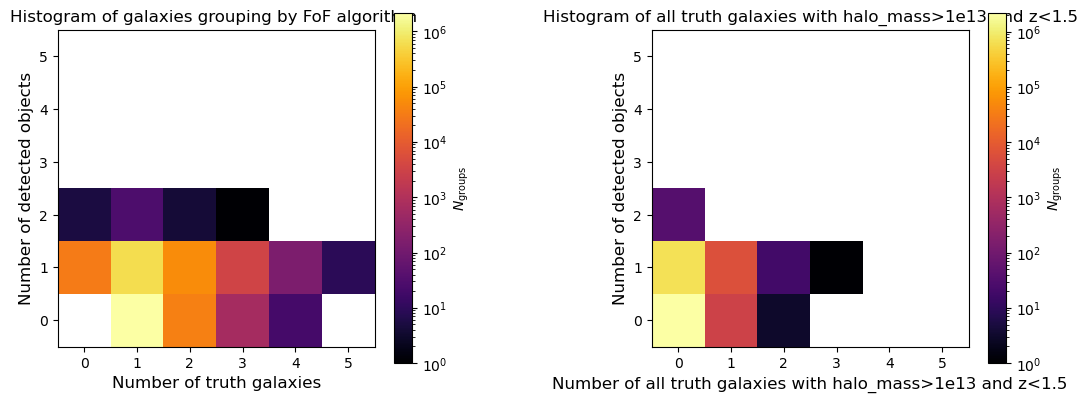

In [109]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_all=plt.hist2d(n_truth_2cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all truth galaxies with halo_mass>1e13 and z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all truth galaxies with halo_mass>1e13 and z<1.5')

plt.show()

In [110]:
print("missed detections :")

print("nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13=", hist2d2_2cut_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_all[0][2,1])

missed detections :
nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13= 3073.0
recognized blending :
nbr of (1-1) systems = 6073.0
unrecognized blending :
nbr of (2-1) systems = 19.0


In [111]:
print("% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,0]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

print("% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

print("% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][2,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 33.427607962580225
% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 66.06113347111932
% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 0.2066789948874143


## Halo_mass >1e13 + z-max-cut study for central galaxies :

In [112]:
n_truth_2cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)

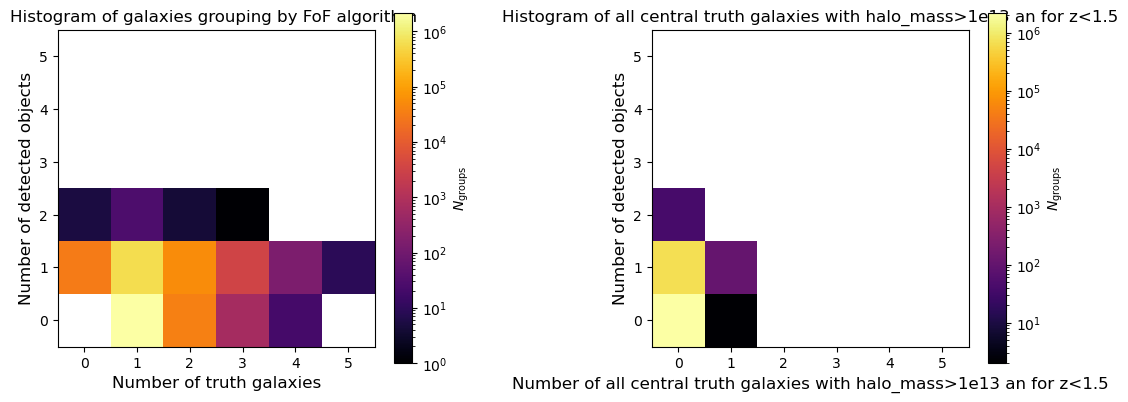

In [113]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_central=plt.hist2d(n_truth_2cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all central truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [114]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 =", hist2d2_2cut_central[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_central[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 = 2.0
recognized blending :
nbr of (1-1) systems = 106.0
unrecognized blending :
nbr of (2-1) systems = 0.0


In [115]:
print("% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]))*100)

% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 1.8518518518518516
% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 98.14814814814815
% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 0.0


## Halo_mass >1e13 + z-max-cut study for sat galaxies :

In [116]:
n_truth_2cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]['group_id'],
                               minlength=n_groups)

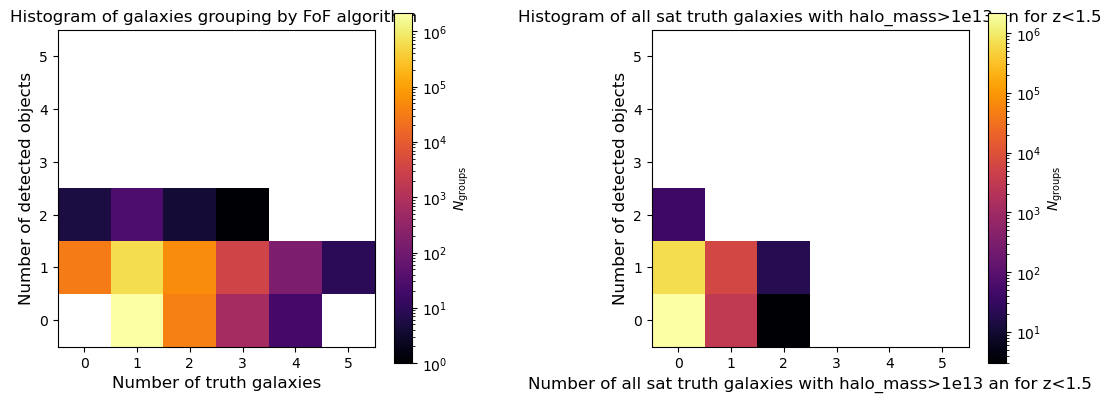

In [117]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_sat=plt.hist2d(n_truth_2cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all sat truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all sat truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [118]:
print("missed detections :")

print("nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 =", hist2d2_2cut_sat[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 = 3071.0
recognized blending :
nbr of (1-1) systems = 5970.0
unrecognized blending :
nbr of (2-1) systems = 19.0


In [119]:
print("% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]))*100)

print("% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]))*100)

print("% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]))*100)

% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 33.80297193175564
% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 65.71271326362135
% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 0.20913593835993394


# (1-0) system study :

In [120]:
##### cut et différents objets utiles :

# galaxy central selection :

ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

####################################################################################

truth_data_halo_mass= truth_data['halo_mass'][ind_galax]
truth_data_z= truth_data['redshift'][ind_galax]

#cut :

halo_mass_cut_13=1e13
halo_mass_cut_14=1e14
z_max_cut= 1.5

In [121]:
#(1-0) systems mask with z and mass cut :

system_1_0_mask= np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 0)))

In [122]:
#selection indice des galaxies présentes dans les systèmes 1-0 :

system_1_0_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 0)))
system_1_0_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 0)))
system_1_0_mask_sat= np.in1d(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_sat == 1) & (n_object == 0)))

ind_truth_all_1_0=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]][system_1_0_mask_all]['row_index']
ind_truth_central_1_0=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]][system_1_0_mask_central]['row_index']
ind_truth_sat_1_0=results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut_13))[0]][system_1_0_mask_sat]['row_index']

In [123]:
print(len(system_1_0_mask_all))

print(len(ind_truth_all_1_0))

31876
3073


In [124]:
len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]][system_1_0_mask_all]['row_index'])

3073

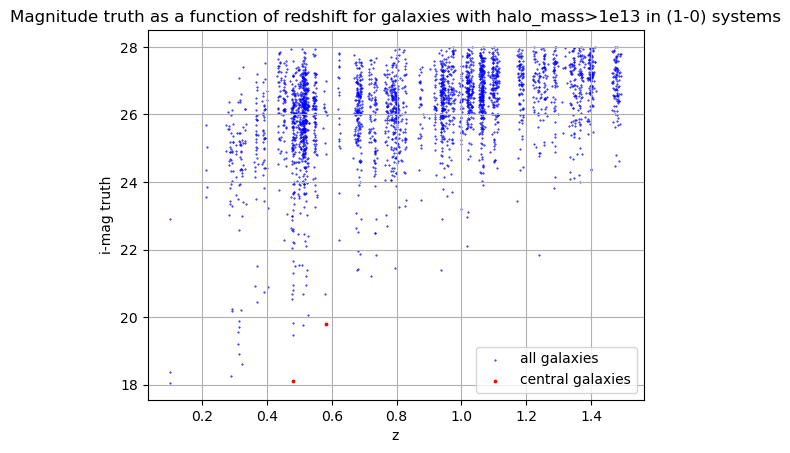

In [125]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_0], truth_data['mag_i'][ind_truth_all_1_0], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_0], truth_data['mag_i'][ind_truth_central_1_0], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('i-mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies with halo_mass>1e13 in (1-0) systems')
plt.legend()
plt.grid()
plt.show()

In [126]:
print("% of galaxy in (1-0) systems in the different clusters =", (len(ind_truth_all_1_0)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

% of galaxy in (1-0) systems in the different clusters = 9.640481867235538


In [127]:
len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]])

31876

In [128]:
len(system_1_0_mask_all)

31876

In [129]:
#Coordinates of the truth and detected objects :

truth_sc_1_0_all = SkyCoord(truth_data['ra'][ind_truth_all_1_0], truth_data['dec'][ind_truth_all_1_0], unit="deg")

ra_truth_1_0_all = truth_sc_1_0_all.ra
dec_truth_1_0_all = truth_sc_1_0_all.dec

#########

truth_sc_1_0_central = SkyCoord(truth_data['ra'][ind_truth_central_1_0], truth_data['dec'][ind_truth_central_1_0], unit="deg")


ra_truth_1_0_central = truth_sc_1_0_central.ra
dec_truth_1_0_central = truth_sc_1_0_central.dec

In [130]:
#Coordinates of the truth and detected objects :

truth_sc_1_1_all = SkyCoord(truth_data['ra'][ind_truth_all_1_1], truth_data['dec'][ind_truth_all_1_1], unit="deg")

ra_truth_1_1_all = truth_sc_1_1_all.ra
dec_truth_1_1_all = truth_sc_1_1_all.dec

#########

truth_sc_1_1_central = SkyCoord(truth_data['ra'][ind_truth_central_1_1], truth_data['dec'][ind_truth_central_1_1], unit="deg")


ra_truth_1_1_central = truth_sc_1_1_central.ra
dec_truth_1_1_central = truth_sc_1_1_central.dec

In [131]:
ra_truth_1_1_all

<Longitude [58.09456091, 58.12311222, 58.10893051, ..., 56.57076599,
            56.6021151 , 56.46329723] deg>

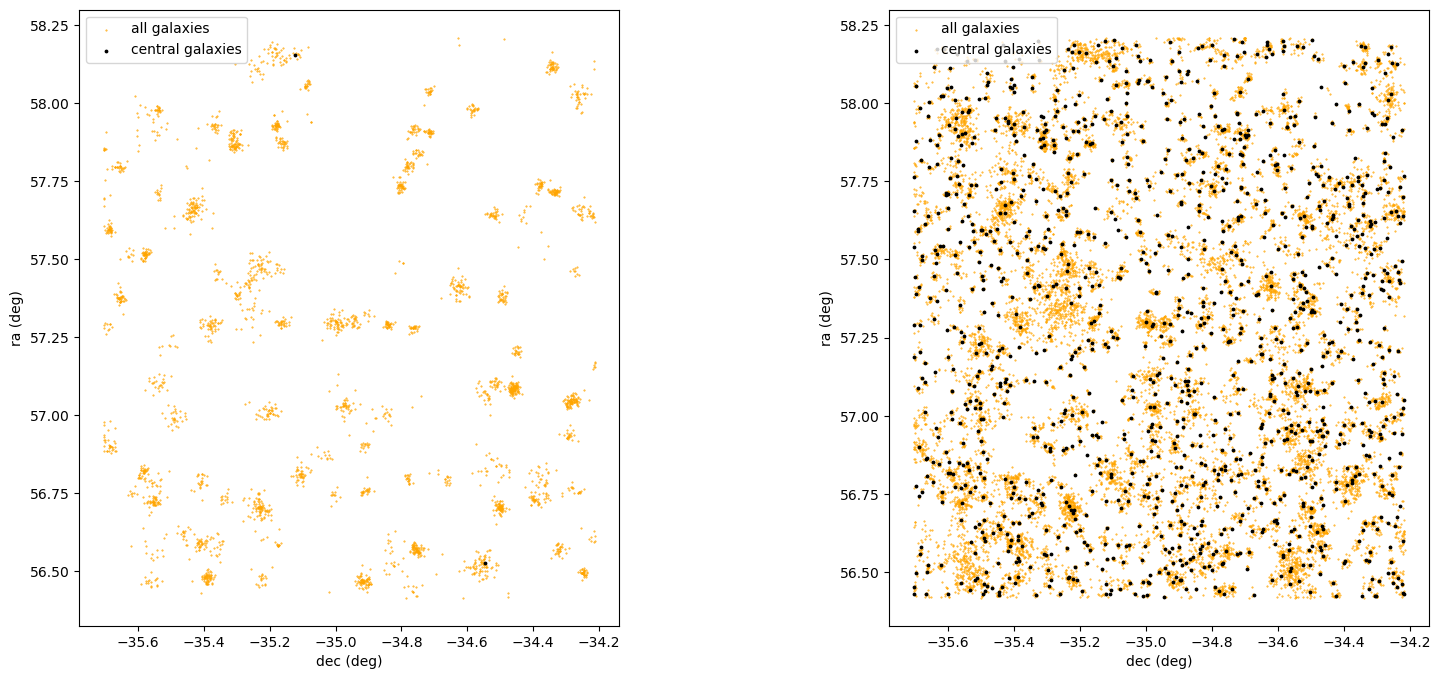

In [132]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
plt.scatter(dec_truth_1_0_all, ra_truth_1_0_all, s=0.2, label='all galaxies', color='orange')
plt.scatter(dec_truth_1_0_central, ra_truth_1_0_central, s=3, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec (deg)')
plt.ylabel('ra (deg)')

plt2=plt.subplot(122)
plt.scatter(dec_truth_1_1_all, ra_truth_1_1_all, s=0.2, label='all galaxies', color='orange')
plt.scatter(dec_truth_1_1_central, ra_truth_1_1_central, s=3, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec (deg)')
plt.ylabel('ra (deg)')

plt.show()

Text(0, 0.5, 'ra (deg)')

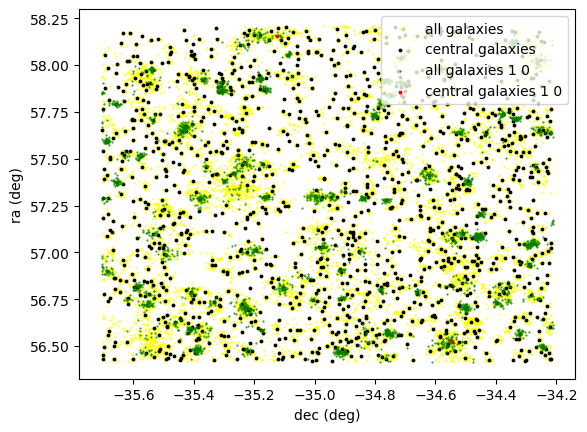

In [133]:
plt.scatter(dec_truth_1_1_all, ra_truth_1_1_all, s=0.2, label='all galaxies', color='yellow')
plt.scatter(dec_truth_1_1_central, ra_truth_1_1_central, s=3, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec (deg)')
plt.ylabel('ra (deg)')

plt.scatter(dec_truth_1_0_all, ra_truth_1_0_all, s=0.2, label='all galaxies 1 0', color='g')
plt.scatter(dec_truth_1_0_central, ra_truth_1_0_central, s=3, label='central galaxies 1 0', color='red')
plt.legend()
plt.xlabel('dec (deg)')
plt.ylabel('ra (deg)')

Text(0, 0.5, 'object i-mag')

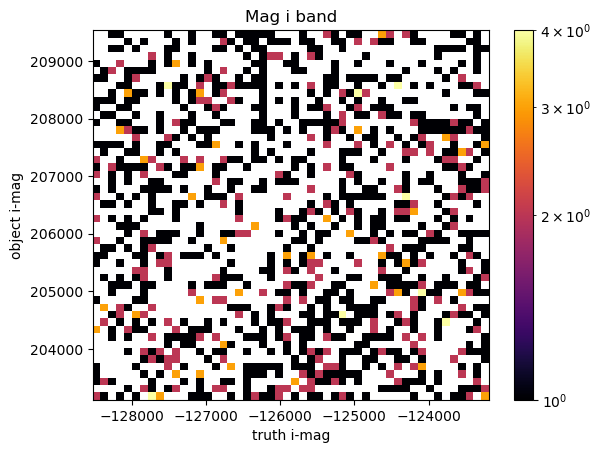

In [65]:
plt.title("Mag i band")
#plt.hist2d(dec_truth_1_1_all, ra_truth_1_1_all, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.hist2d(dec_truth_1_1_central, ra_truth_1_1_central, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
#plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")

In [50]:
truth_data.items()

dict_items([('galaxy_id', array([5000004901, 5000004903, 5000022195, ..., 6895875237, 6895875556,
       6895876060])), ('redshift', array([0.10237548, 0.10204245, 0.177175  , ..., 3.01861503, 3.01032883,
       3.01116588])), ('halo_id', array([    32200080442,     32200080442,   -469500080421, ...,
       -63727400110121, -63759300110121, -63809700110121])), ('is_central', array([False, False,  True, ...,  True,  True,  True])), ('ra', array([57.69217614, 57.60349094, 57.65726924, ..., 57.85832014,
       56.65864023, 57.45267116])), ('mag_i', array([22.21021996, 19.55688363, 23.95609176, ..., 27.34835302,
       27.39341073, 27.73426946])), ('dec', array([-34.22003549, -34.25492927, -34.22595544, ..., -34.66771993,
       -35.63162329, -34.86360762])), ('halo_mass', array([5.07006249e+12, 5.07006249e+12, 3.79915201e+10, ...,
       3.90086208e+10, 5.72330995e+10, 3.13850793e+10]))])

In [51]:
object_data.items()

dict_items([('ra', array([58.20039686, 58.17906019, 58.10063705, ..., 56.49458612,
       56.47827669, 56.47829392])), ('mag_i_cModel', array([24.45465915, 25.90490771, 24.49308983, ..., 26.06210094,
       26.14738811, 26.36562786])), ('photoz_mean', array([1.431902  , 0.65773267, 0.27109018, ..., 1.2237338 , 1.6302474 ,
       1.2578402 ], dtype=float32)), ('dec', array([-35.70227161, -35.7020672 , -35.70243742, ..., -34.21682109,
       -34.21639739, -34.21698917]))])

## (1-1) systems :

In [52]:
#selection indice des galaxies présentes dans les systèmes 1-1 :

system_1_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))
system_1_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 1)))

ind_truth_all_1_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]][system_1_1_mask_all]['row_index']
ind_truth_central_1_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]][system_1_1_mask_central]['row_index']

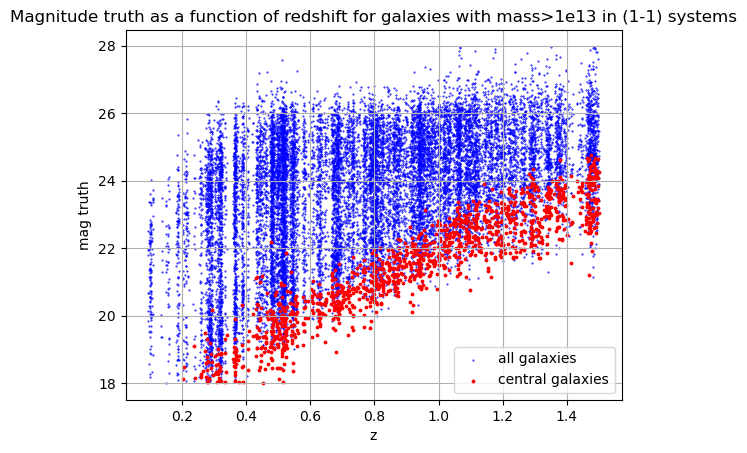

In [53]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_1], truth_data['mag_i'][ind_truth_all_1_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_1], truth_data['mag_i'][ind_truth_central_1_1], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies with mass>1e13 in (1-1) systems')
plt.legend()
plt.grid()
plt.show()

In [54]:
print("% of (1-1) systems in the different clusters =", (len(ind_truth_all_1_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

% of (1-1) systems in the different clusters = 61.535324381980175


In [55]:
system_1_1_mask_all_obj= np.in1d(results[object_mask]['group_id'], np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))

ind_truth_object_1_1=results[object_mask][system_1_1_mask_all_obj]['row_index']

Text(0, 0.5, 'blended object magnitude')

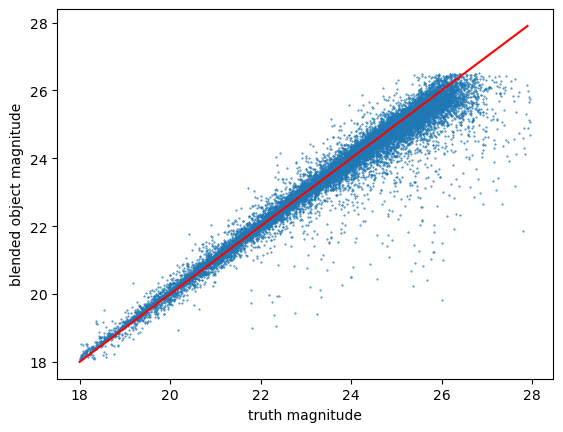

In [56]:
x=np.arange(18, 28, 0.1)

plt.figure()
plt.scatter(truth_data['mag_i'][ind_truth_all_1_1], object_data['mag_i_cModel'][ind_truth_object_1_1], s=0.2)
plt.plot(x, x, 'r')
plt.xlabel('truth magnitude')
plt.ylabel('blended object magnitude')

Text(0, 0.5, 'object i-mag')

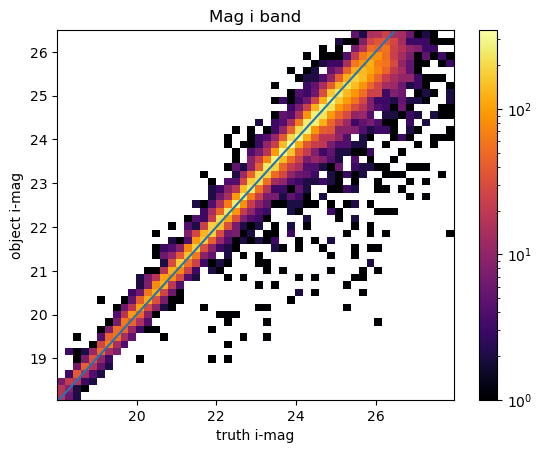

In [57]:
plt.title("Mag i band")
plt.hist2d(truth_data['mag_i'][ind_truth_all_1_1], object_data['mag_i_cModel'][ind_truth_object_1_1], bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")

## (2-1) systems :

In [58]:
#selection indice des galaxies présentes dans les systèmes 2-1 :

system_2_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 2) & (n_object == 1)))
system_2_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 2) & (n_object == 1)))

ind_truth_all_2_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]][system_2_1_mask_all]['row_index']
ind_truth_central_2_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut_13))[0]][system_2_1_mask_central]['row_index']

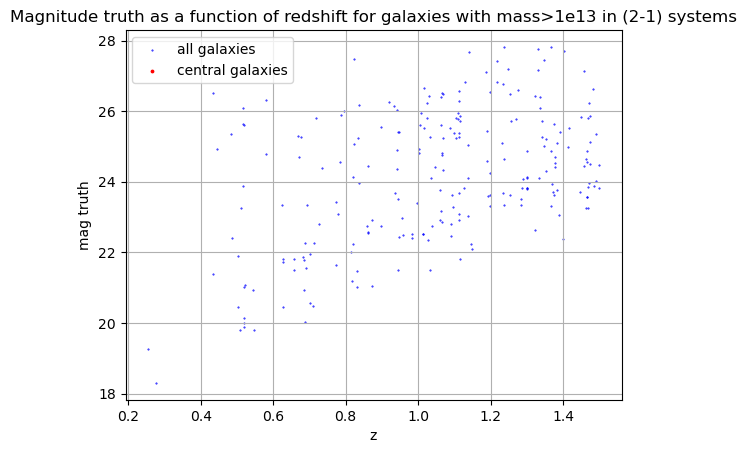

In [59]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_2_1], truth_data['mag_i'][ind_truth_all_2_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_2_1], truth_data['mag_i'][ind_truth_central_2_1], s=3, label='central galaxies', color='red')
plt.xlabel('z')
plt.ylabel('mag truth')
plt.title('Magnitude truth as a function of redshift for galaxies with mass>1e13 in (2-1) systems')
plt.legend()
plt.grid()
plt.show()

In [61]:
print("% of (2-1) systems in the different clusters =", (len(ind_truth_all_2_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13))[0]]))*100)

print("petit pourcentage mais normal puisque l'on prend toutes les galaxies et pas les galaxies qui sont les moins brillantes du coup plus susceptible au blending")

% of (2-1) systems in the different clusters = 0.7278203036767474
petit pourcentage mais normal puisque l'on prend toutes les galaxies et pas les galaxies qui sont les moins brillantes du coup plus susceptible au blending
